# Real Estate Price Predictions

Notebook com predição do preço por unidade de área de casas.  
Dataset extraído do kaggle (https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction)

In [1]:

# Importando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from stepwise_process.statsmodels import stepwise
from sfrancia import shapiroFrancia
from scipy.stats import norm
from scipy.stats import boxcox
import re
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Visualizando os dados
df = pd.read_csv('Real estate.csv')

In [3]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


#

## Data Cleaning

In [4]:
# Drop da primeira coluna
df.drop('No', axis=1, inplace = True)

In [5]:
# Renomeando as colunas
df.rename(columns= {'X1 transaction date': 'Data Transacao',
                    'X2 house age': 'Idade casa',
                    'X3 distance to the nearest MRT station': 'Distancia da estacao metro',
                    'X4 number of convenience stores': 'Numero lojas conveniencia',
                    'X5 latitude': 'Latitude',
                    'X6 longitude': 'Longitude',
                    'Y house price of unit area': 'Preco por unidade de area'}, inplace=True)

In [6]:
df.head()

,Data Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [7]:
# Verificação de registros duplicados
df.duplicated().sum() # Não há

0

In [8]:
# Verificação de valores ausentes
df.isna().sum() # Não há

Data Transacao                0
Idade casa                    0
Distancia da estacao metro    0
Numero lojas conveniencia     0
Latitude                      0
Longitude                     0
Preco por unidade de area     0
dtype: int64

## Pré-Processamento de Dados

In [9]:
# Separando a coluna "Data Transacao" em ano e mês.
ano_mes = df['Data Transacao'].apply(lambda x: str(x).split('.'))

ano = [year[0] for year in ano_mes]
mes = [month[1] for month in ano_mes]

df['Ano Transacao'] = ano
df['Mes Transacao'] = mes


In [10]:
df.head()

,Data Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area,Ano Transacao,Mes Transacao
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9,2012,917
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2,2012,917
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3,2013,583
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8,2013,5
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1,2012,833


In [11]:
# Mudar posiçao das colunas de data e remover a inicial
mudar_posicao1 = df.pop('Ano Transacao')
mudar_posicao2 = df.pop('Mes Transacao')
remove_coluna = df.pop('Data Transacao')

df.insert(0, 'Ano Transacao', mudar_posicao1)
df.insert(1, 'Mes Transacao', mudar_posicao2)

In [12]:
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012,917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,5,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,833,5.0,390.56840,5,24.97937,121.54245,43.1


In [13]:
# Agora é preciso adequar a coluna 'Mes Transacao' para ficar de 0 a 12 (Jan-Dez)
df['Mes Transacao'] = [int(mes)/83.33 for mes in df['Mes Transacao']]
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012,11.004440,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,11.004440,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,6.996280,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,0.060002,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,9.996400,5.0,390.56840,5,24.97937,121.54245,43.1


In [14]:
for i in range(0, len(df)):
    if df['Mes Transacao'][i] < 1:
         df['Mes Transacao'][i] = 1
    elif df['Mes Transacao'][i] < 2:
         df['Mes Transacao'][i] = 2
    elif df['Mes Transacao'][i] < 3:
         df['Mes Transacao'][i] = 3
    elif df['Mes Transacao'][i] < 4:
         df['Mes Transacao'][i] = 4
    elif df['Mes Transacao'][i] < 5:
         df['Mes Transacao'][i] = 5
    elif df['Mes Transacao'][i] < 6:
         df['Mes Transacao'][i] = 6
    elif df['Mes Transacao'][i] < 7:
         df['Mes Transacao'][i] = 7
    elif df['Mes Transacao'][i] < 8:
         df['Mes Transacao'][i] = 8
    elif df['Mes Transacao'][i] < 9:
         df['Mes Transacao'][i] = 9
    elif df['Mes Transacao'][i] < 10:
         df['Mes Transacao'][i] = 10
    elif df['Mes Transacao'][i] < 11:
         df['Mes Transacao'][i] = 11
    elif df['Mes Transacao'][i] < 12:
         df['Mes Transacao'][i] = 12

# Transformndo a coluna de mês em inteiro
df = df.astype({'Mes Transacao': 'int'})
df = df.astype({'Ano Transacao': 'int'})

In [15]:
df[(df['Mes Transacao']== '1')]

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area


In [16]:
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012,12,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,12,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,7,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,1,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,10,5.0,390.56840,5,24.97937,121.54245,43.1


In [17]:
# Removendo as colunas 'Latitude' e 'Longitude' pois não serão necessárias.
df.drop(['Latitude', 'Longitude'],axis =1 , inplace = True)
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area
0,2012,12,32.0,84.87882,10,37.9
1,2012,12,19.5,306.59470,9,42.2
2,2013,7,13.3,561.98450,5,47.3
3,2013,1,13.3,561.98450,5,54.8
4,2012,10,5.0,390.56840,5,43.1


## Análise Exploratória

In [18]:
df.describe()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2012.695652,4.628019,17.712560,1083.885689,4.094203,37.980193
std,0.460687,3.880389,11.392485,1262.109595,2.945562,13.606488
min,2012.000000,1.000000,0.000000,23.382840,0.000000,7.600000
25%,2012.000000,1.000000,9.025000,289.324800,1.000000,27.700000
50%,2013.000000,4.000000,16.100000,492.231300,4.000000,38.450000
75%,2013.000000,7.000000,28.150000,1454.279000,6.000000,46.600000
max,2013.000000,12.000000,43.800000,6488.021000,10.000000,117.500000


<Figure size 1500x800 with 0 Axes>

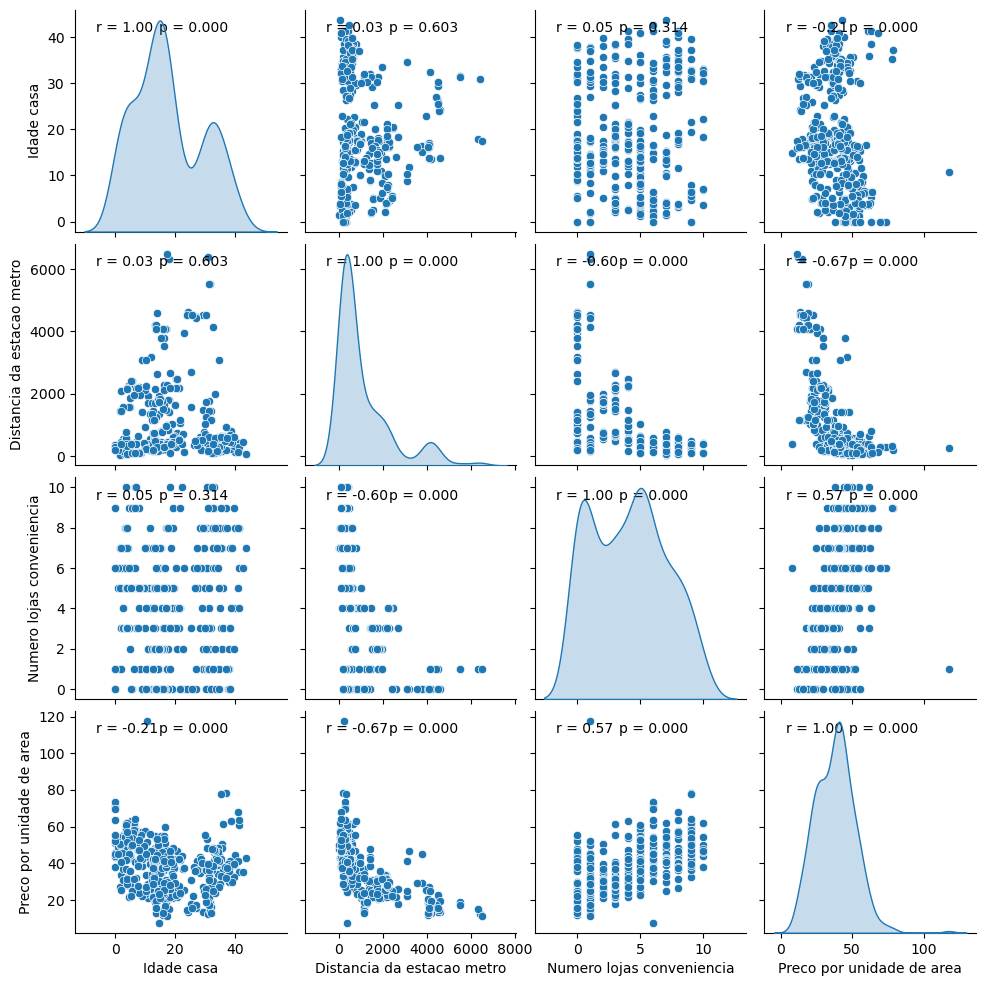

In [19]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y) # r² e p-val
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

plt.figure(figsize=(15,8))
graph = sns.pairplot(df.loc[:,"Idade casa":"Preco por unidade de area"], diag_kind="kde")
graph.map(corrfunc)
plt.show()

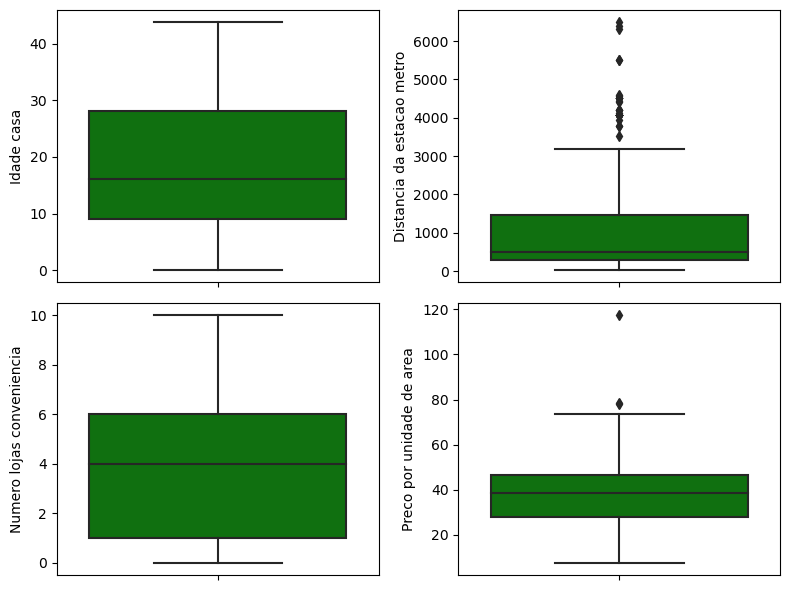

In [20]:
# Boxplot das variáveis quant contínuas
box_columns = ['Idade casa','Distancia da estacao metro', 'Numero lojas conveniencia', 'Preco por unidade de area']
fig, ax = plt.subplots(figsize=(8,6), nrows = 2, ncols = 2)

for i, col in enumerate(box_columns):
    sns.boxplot(y= df[col],ax=ax[i//2, i%2], color = 'green')
fig.tight_layout()



### Tratamento de Outliers

> É possível verificar a presença de alguns outliers nas variáveis 'preco por unidade de area' e 'distancia da estacao'

In [21]:
print(f"Número de outliers na variável 'Distancia da estacao metro': {(stats.zscore(df['Distancia da estacao metro']) > abs(3)).sum()}")
print(f"Número de outliers na variável 'Preco por unidade de area'': {(stats.zscore(df['Preco por unidade de area']) > abs(3)).sum()}")
print(f"Número de outliers na variável 'Numero lojas conveniencia': {(stats.zscore(df['Numero lojas conveniencia']) > abs(3)).sum()}")
print(f"Número de outliers na variável 'Idade casa': {(stats.zscore(df['Idade casa']) > abs(3)).sum()}")

Número de outliers na variável 'Distancia da estacao metro': 5
Número de outliers na variável 'Preco por unidade de area'': 1
Número de outliers na variável 'Numero lojas conveniencia': 0
Número de outliers na variável 'Idade casa': 0


> No entanto, apesar de ser possível tratar outliers via zscore, não será a melhor alternativa nesse caso, pois as variáveis não estão normalmente distribuídas e ao remover os outliers originais, novos podem aparecer, como exemplificado abaixo.  
> Ao removermos os 5 outliers que tínhamos, 8 novos outliers aparecem.

In [22]:
df_teste = df[(stats.zscore(df['Distancia da estacao metro']) < abs(3))]
print(f"Número de outliers na variável 'Distancia da estacao metro': {(stats.zscore(df_teste['Distancia da estacao metro']) > abs(3)).sum()}")

Número de outliers na variável 'Distancia da estacao metro': 8


> Portanto, iremos fazer por IQR

In [23]:
# Função para tratar outliers

def remove_outliers(df, colunas):
    clean_df = df.copy()
    
    for col in colunas:
        # quartil 1, quartil 3 e IQR
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
    
        # Calcular limites superior e inferior
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Identificar o indice das colunas com outliers para ser removidos posteriormente
        
        outlier_indices = clean_df[(clean_df[col] < limite_inferior) | (clean_df[col] > limite_superior)].index

        # Remove os outliers do dataset nessa coluna
        clean_df.drop(outlier_indices, inplace=True)
    
    return clean_df
        

In [24]:
#Objeto com as colunas a serem tratados
col_outliers = ['Distancia da estacao metro','Preco por unidade de area']
df = remove_outliers(df, col_outliers)

In [25]:
#############

In [26]:
# Não temos todos os meses do ano. Ao inves de separar por mês, talvez seja ideal separar por quarter (trimestre).
df['Mes Transacao'].unique()

array([12,  7,  1, 10,  9,  6,  4,  3])

In [27]:
df.sample(10)

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area
80,2013,1,11.8,533.4762,4,40.3
171,2013,1,3.6,383.8624,5,58.8
22,2012,12,14.7,1360.1390,1,24.6
168,2013,1,27.6,515.1122,5,37.4
137,2013,1,13.6,319.0708,6,47.4
303,2013,1,38.3,439.7105,0,38.4
190,2013,1,35.3,616.5735,8,42.3
297,2012,10,34.9,567.0349,4,28.5
302,2013,1,16.5,2288.0110,3,23.2
85,2012,1,0.0,338.9679,9,50.8


In [28]:
# Transformando a coluna mes em trimestre.
def trimestre_from_mes(mes):
    if mes <= 3:
        return 'Q1'
    elif mes <= 6:
        return 'Q2'
    elif mes <= 9:
        return 'Q3'    
    elif mes <= 12:
        return 'Q4'

df['Mes Transacao'] = df['Mes Transacao'].apply(lambda x: trimestre_from_mes(x))
df['Mes Transacao'].unique()

array(['Q4', 'Q3', 'Q1', 'Q2'], dtype=object)

In [29]:
# Temos apenas dois anos diferentes
df['Ano Transacao'].value_counts()

2013    257
2012    116
Name: Ano Transacao, dtype: int64

<AxesSubplot:>

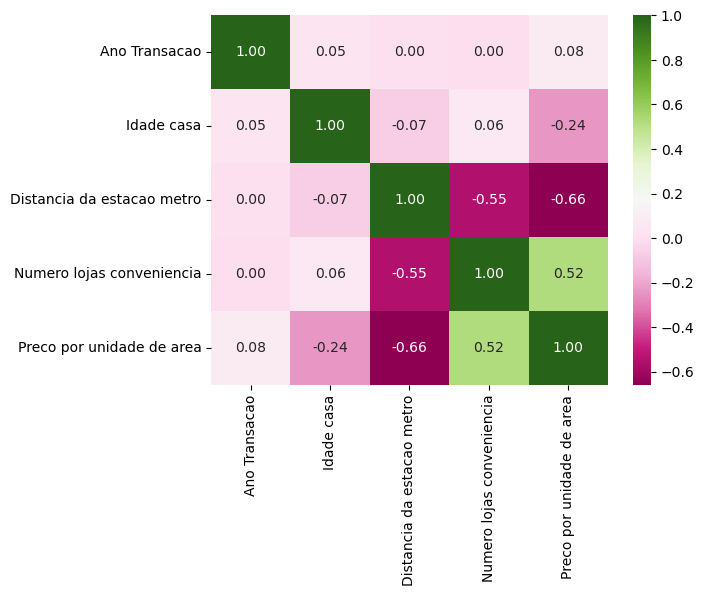

In [30]:
# Correlação
correlacao = df.corr()
sns.heatmap(correlacao, cmap = 'PiYG', annot = True, fmt = '.2f')

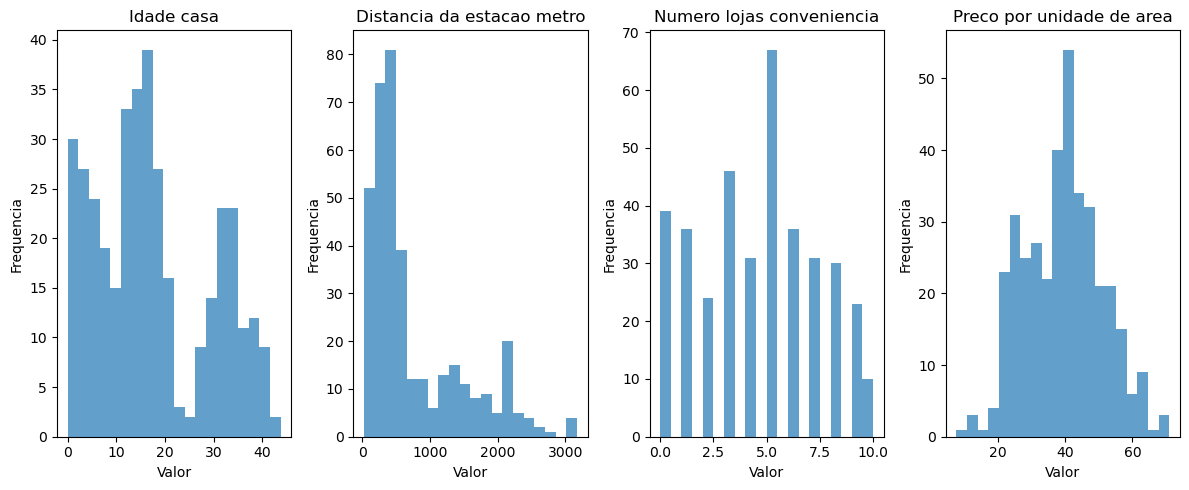

In [31]:
# Visualização das variáveis preditoras
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(12,5))

# Numero de bins
bins = 20

var_pred = [df['Idade casa'], df['Distancia da estacao metro'], df['Numero lojas conveniencia'], df['Preco por unidade de area']]

for i, data in enumerate(var_pred):
    axs[i].hist(data, bins = bins, alpha = 0.7)
    axs[i].set_xlabel('Valor')
    axs[i].set_ylabel('Frequencia')
    axs[i].set_title(f'{df.columns[i+2]}')
    
plt.tight_layout()
    
plt.show()

### Dummização das variáveis Ano e Mês

In [32]:
df_dummies = pd.get_dummies(df, columns=['Ano Transacao', 'Mes Transacao'], drop_first= True)
df_dummies.head()

,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area,Ano Transacao_2013,Mes Transacao_Q2,Mes Transacao_Q3,Mes Transacao_Q4
0,32.0,84.87882,10,37.9,0,0,0,1
1,19.5,306.59470,9,42.2,0,0,0,1
2,13.3,561.98450,5,47.3,1,0,1,0
3,13.3,561.98450,5,54.8,1,0,0,0
4,5.0,390.56840,5,43.1,0,0,0,1


## Modelo 1

> Modelo usando o algortimo LinearRegression do pacote scikitleran

In [33]:
# Separando os dados em dados de treino e dados de teste
X = df_dummies.drop('Preco por unidade de area', axis = 1)
y = df_dummies['Preco por unidade de area']

X_train, X_teste, y_train, y_teste = train_test_split(X, y, test_size=0.25)

In [34]:
X_train.reset_index(drop=True, inplace=True)
X_teste.reset_index(drop=True, inplace=True)

In [35]:
# Vamos fazer a padronização dos dados visto que as variáveis se encontram em grandezas diferentes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Idade casa', 'Distancia da estacao metro', 'Numero lojas conveniencia']])
X_teste_scaled = scaler.transform(X_teste[['Idade casa', 'Distancia da estacao metro', 'Numero lojas conveniencia']])

In [36]:
# Transformando os ddos padronizados em dataframes
X_train_scaled = pd.DataFrame(X_train_scaled)
X_teste_scaled = pd.DataFrame(X_teste_scaled)

In [37]:
# Juntando aos dados de treino e removendo os originais
X_train['Idade casa'] = X_train_scaled[0]
X_train['Distancia da estacao metro'] = X_train_scaled[1]
X_train['Numero lojas conveniencia'] = X_train_scaled[2]
X_teste['Idade casa'] = X_teste_scaled[0]
X_teste['Distancia da estacao metro'] = X_teste_scaled[1]
X_teste['Numero lojas conveniencia'] = X_teste_scaled[2]

In [38]:
# Verificar se foi devidamente padronizado
print(f'Desvio Padrao: {X_train.std()}')
print(f'Média: {X_train.mean()}')

Desvio Padrao: Idade casa                    1.001797
Distancia da estacao metro    1.001797
Numero lojas conveniencia     1.001797
Ano Transacao_2013            0.461090
Mes Transacao_Q2              0.416487
Mes Transacao_Q3              0.327716
Mes Transacao_Q4              0.371734
dtype: float64
Média: Idade casa                    3.541572e-17
Distancia da estacao metro   -1.412649e-16
Numero lojas conveniencia    -9.729374e-17
Ano Transacao_2013            6.953405e-01
Mes Transacao_Q2              2.222222e-01
Mes Transacao_Q3              1.218638e-01
Mes Transacao_Q4              1.648746e-01
dtype: float64


In [39]:
# Modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [40]:
# Coeficientes
coef = modelo.coef_
pd.DataFrame(data = coef, index = X.columns, columns=['Coeficientes'])

,Coeficientes
Idade casa,-3.582941
Distancia da estacao metro,-6.261917
Numero lojas conveniencia,2.658074
Ano Transacao_2013,3.496763
Mes Transacao_Q2,-2.087325
Mes Transacao_Q3,1.067348
Mes Transacao_Q4,0.698602


In [41]:
# Intercepto
modelo.intercept_

36.4423536203209

In [42]:
y_predicted = modelo.predict(X_teste)

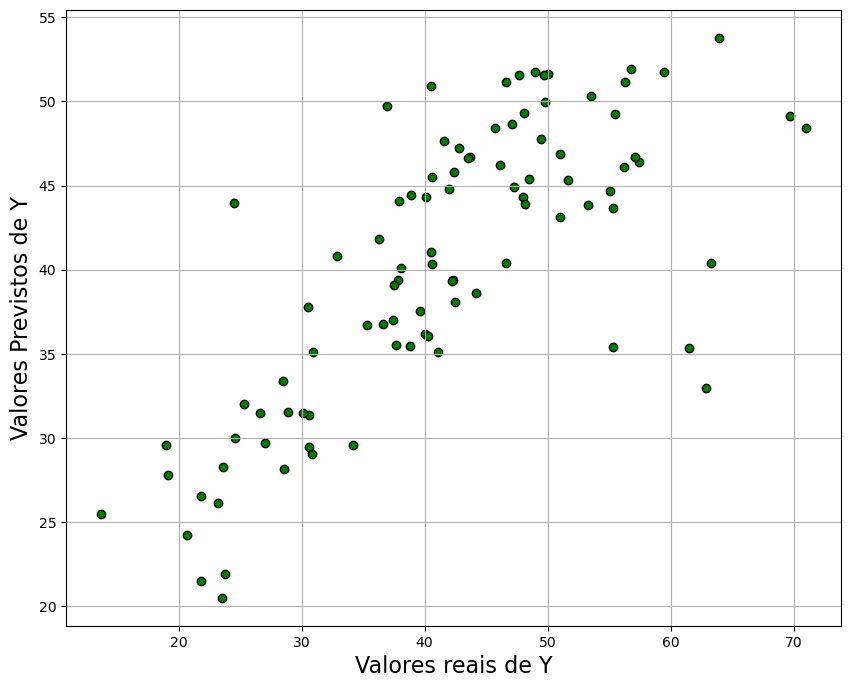

In [43]:
# Plot dos dados previstos com os reais
plt.figure(figsize=(10,8))

plt.scatter(x = y_teste, y = y_predicted, color = 'green', edgecolors= 'black')
plt.xlabel('Valores reais de Y', fontdict={'fontsize': 16})
plt.ylabel('Valores Previstos de Y', fontdict={'fontsize': 16})
plt.grid(True)

In [44]:
# Métricas de avaliação do modelo
mean_squared_error(y_teste, y_predicted)# Mean Squared Error

67.93689321579627

In [45]:
mean_absolute_error(y_teste, y_predicted)# MAE - Mean Absolute Error

5.836129222608775

In [46]:
R2 = r2_score(y_teste, y_predicted) # R²
print(f'Valor de R²: {round(R2,3)}')

Valor de R²: 0.549


> Refazer esse Modelo1, agora com a remoção de algumas das variáveis preditivas não relevantes

In [47]:
# Visualização novamente do mapa de correlação
df_dummies.corr()


,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area,Ano Transacao_2013,Mes Transacao_Q2,Mes Transacao_Q3,Mes Transacao_Q4
Idade casa,1.000000,-0.066745,0.064660,-0.238996,0.046681,-0.053168,0.056346,-0.037724
Distancia da estacao metro,-0.066745,1.000000,-0.553205,-0.658970,0.003508,0.025666,-0.024690,0.060761
Numero lojas conveniencia,0.064660,-0.553205,1.000000,0.524921,0.001155,0.042709,0.066555,-0.050837
Preco por unidade de area,-0.238996,-0.658970,0.524921,1.000000,0.075785,-0.012184,0.028666,-0.091836
Ano Transacao_2013,0.046681,0.003508,0.001155,0.075785,1.000000,0.348259,-0.226103,-0.677405
Mes Transacao_Q2,-0.053168,0.025666,0.042709,-0.012184,0.348259,1.000000,-0.199214,-0.235912
Mes Transacao_Q3,0.056346,-0.024690,0.066555,0.028666,-0.226103,-0.199214,1.000000,-0.174900
Mes Transacao_Q4,-0.037724,0.060761,-0.050837,-0.091836,-0.677405,-0.235912,-0.174900,1.000000


In [48]:
# Procedimento stepwise
step = SequentialFeatureSelector(modelo, direction='forward', scoring='r2')

In [49]:
step.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), scoring='r2')

In [50]:
# Variáveis de Saída
variaveis_entrada = step.feature_names_in_
variaveis_saida = step.get_feature_names_out(input_features= variaveis_entrada)
variaveis_saida

array(['Idade casa', 'Distancia da estacao metro',
       'Numero lojas conveniencia'], dtype=object)

In [51]:
X_train_final = X_train[['Idade casa', 'Distancia da estacao metro','Numero lojas conveniencia']]
X_teste_final = X_teste[['Idade casa', 'Distancia da estacao metro','Numero lojas conveniencia']]

In [52]:
modelo1 = LinearRegression()
modelo1.fit(X_train_final, y_train)

LinearRegression()

In [53]:
# Coeficientes
coef = modelo1.coef_
pd.DataFrame(data = coef, index = X_train_final.columns, columns=['Coeficientes'])

,Coeficientes
Idade casa,-3.507464
Distancia da estacao metro,-6.340336
Numero lojas conveniencia,2.518358


In [54]:
# Intercepto
modelo.intercept_

36.4423536203209

In [55]:
# Predição dos valores
y_predicted = modelo1.predict(X_teste_final)

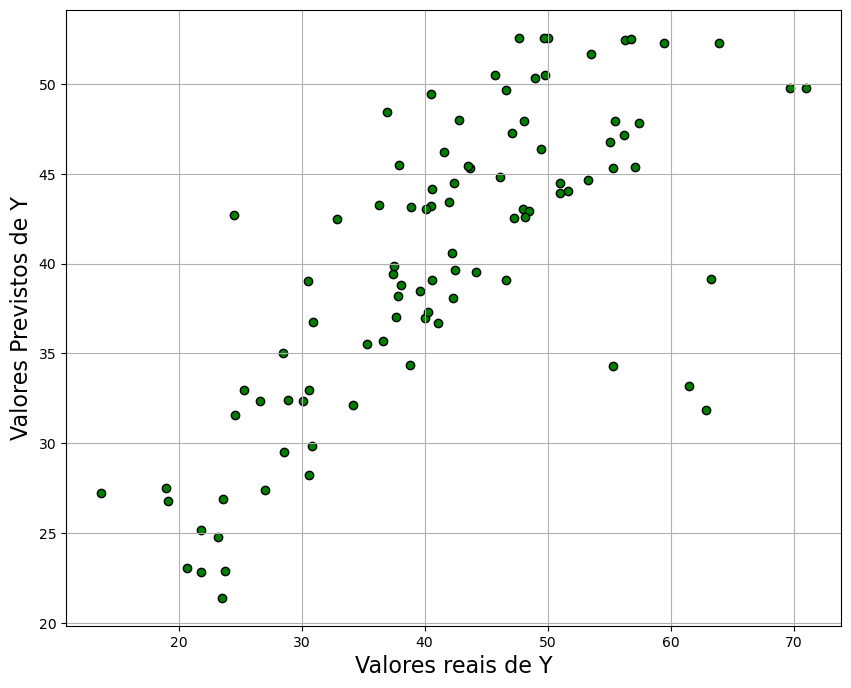

In [56]:
# Plot dos dados previstos com os reais
plt.figure(figsize=(10,8))

plt.scatter(x = y_teste, y = y_predicted, color = 'green', edgecolors= 'black')
plt.xlabel('Valores reais de Y', fontdict={'fontsize': 16})
plt.ylabel('Valores Previstos de Y', fontdict={'fontsize': 16})
plt.grid(True)

In [57]:
# R²
R2_1 = r2_score(y_teste, y_predicted)
print(f'Valor de R²: {round(R2_1,3)}')

Valor de R²: 0.539


> R² basicamente se manteve o mesmo, porém é importante remover as variáveis que não sao estatísticamente relevantes 

## Modelo2

> Modelo de Regressão Linear usando o pacote statsmodel.  
> Melhor para visualização resultados estatísticos

In [58]:
# Será necessário renomear as colunas pra nao ter espaço
X.rename(columns={'Mes Transacao_Q3': 'Mes_Transacao_Q3',
                  'Mes Transacao_Q4': 'Mes_Transacao_Q4',
                  'Mes Transacao_Q2': 'Mes_Transacao_Q2',
                  'Ano Transacao_2013': 'Ano_Transacao_2013',
                  'Idade casa': 'Idade_casa',
                  'Distancia da estacao metro': 'Distancia_da_estacao_metro',
                  'Numero lojas conveniencia': 'Numero_lojas_conveniencia',
                  }, inplace=True)
y = y.rename('Preco_por_unidade_de_area')

In [59]:
X.columns

Index(['Idade_casa', 'Distancia_da_estacao_metro', 'Numero_lojas_conveniencia',
       'Ano_Transacao_2013', 'Mes_Transacao_Q2', 'Mes_Transacao_Q3',
       'Mes_Transacao_Q4'],
      dtype='object')

In [60]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['Idade_casa', 'Distancia_da_estacao_metro', 'Numero_lojas_conveniencia']])
X_scaled = pd.DataFrame(X_scaled,columns=['Idade_casa', 'Distancia_da_estacao_metro', 'Numero_lojas_conveniencia'])
X_scaled.head()

,Idade_casa,Distancia_da_estacao_metro,Numero_lojas_conveniencia
0,1.244653,-0.959923,1.983040
1,0.174269,-0.645261,1.625537
2,-0.356642,-0.282808,0.195525
3,-0.356642,-0.282808,0.195525
4,-1.067377,-0.526084,0.195525


In [61]:
# Resetando os index
X_scaled.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [62]:
colunas = ['Idade_casa', 'Distancia_da_estacao_metro', 'Numero_lojas_conveniencia']
for i in colunas:
    X[i] = X_scaled[i]

In [63]:
X

,Idade_casa,Distancia_da_estacao_metro,Numero_lojas_conveniencia,Ano_Transacao_2013,Mes_Transacao_Q2,Mes_Transacao_Q3,Mes_Transacao_Q4
0,1.244653,-0.959923,1.983040,0,0,0,1
1,0.174269,-0.645261,1.625537,0,0,0,1
2,-0.356642,-0.282808,0.195525,1,0,1,0
3,-0.356642,-0.282808,0.195525,1,0,0,0
4,-1.067377,-0.526084,0.195525,0,0,0,1
...,...,...,...,...,...,...,...
368,0.088638,2.007464,-0.519482,1,1,0,0
369,-1.015998,-0.952008,1.625537,0,0,1,0
370,0.114327,-0.525514,0.910531,1,0,0,0
371,-0.801921,-0.931636,0.195525,1,0,0,0


In [64]:
# # Padronizar os dados que nao são binários
# X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns=['Idade_casa', 'Distancia_da_estacao_metro', 'Numero_lojas_conveniencia',
#        'Ano_Transacao_2013', 'Mes_Transacao_Q2', 'Mes_Transacao_Q3',
#        'Mes_Transacao_Q4'])
# X.sample(10)

In [65]:
# Nesse tipo de algoritmo que iremos usar (do pacote statsmodel) não é necessário separar a variável preditora da target, portanto irei juntá-las novamente
df_modelo = pd.concat([X, y], axis = 1)
df_modelo

,Idade_casa,Distancia_da_estacao_metro,Numero_lojas_conveniencia,Ano_Transacao_2013,Mes_Transacao_Q2,Mes_Transacao_Q3,Mes_Transacao_Q4,Preco_por_unidade_de_area
0,1.244653,-0.959923,1.983040,0,0,0,1,37.9
1,0.174269,-0.645261,1.625537,0,0,0,1,42.2
2,-0.356642,-0.282808,0.195525,1,0,1,0,47.3
3,-0.356642,-0.282808,0.195525,1,0,0,0,54.8
4,-1.067377,-0.526084,0.195525,0,0,0,1,43.1
...,...,...,...,...,...,...,...,...
368,0.088638,2.007464,-0.519482,1,1,0,0,28.1
369,-1.015998,-0.952008,1.625537,0,0,1,0,50.0
370,0.114327,-0.525514,0.910531,1,0,0,0,40.6
371,-0.801921,-0.931636,0.195525,1,0,0,0,52.5


In [66]:
modelo_sm = sm.OLS.from_formula('Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro +\
                                            Numero_lojas_conveniencia + Ano_Transacao_2013 + Mes_Transacao_Q2 +\
                                            Mes_Transacao_Q3 + Mes_Transacao_Q4', df_modelo).fit()

In [67]:
# summary do modelo
modelo_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Preco_por_unidade_de_area   R-squared:                       0.569
Model:                                   OLS   Adj. R-squared:                  0.561
Method:                        Least Squares   F-statistic:                     68.78
Date:                       Thu, 23 Mar 2023   Prob (F-statistic):           7.29e-63
Time:                               11:22:40   Log-Likelihood:                -1284.6
No. Observations:                        373   AIC:                             2585.
Df Residuals:                            365   BIC:                             2617.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     36.8689      1.302     28.309      0.000      34.308      39.430
Idade_casa                    -3.4855      0.400     -8.714      0.000      -4.272      -2.699
Distancia_da_estacao_metro    -6.2720      0.479    -13.099      0.000      -7.214      -5.330
Numero_lojas_conveniencia      2.8254      0.479      5.899      0.000       1.884       3.767
Ano_Transacao_2013             3.6023      1.349      2.670      0.008       0.949       6.255
Mes_Transacao_Q2              -1.6534      1.053     -1.570      0.117      -3.724       0.417
Mes_Transacao_Q3               1.4781      1.389      1.064      0.288      -1.254       4.210
Mes_Transacao_Q4               1.0358      1.619      0.640      0.523      -2.147       4.219
==============================================================================
Omnibus:                       55.275   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.209
Skew:                           0.582   Prob(JB):                     1.37e-46
Kurtosis:                       6.498   Cond. No.                         7.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Segundo esse summary, as únicas variáveis que não passaram no teste t foram as de 'Mes_Transacao' (não foram estatísticamente significante).  
> Iremos aplicar então o procedimento stepwise que deve retirar todas as variáveis que não são estatisticamente siognificantes

### StepWise

> Irei aplicar o procedimento stepwise para decidir quais variáveis devem ficar no modelo

In [68]:
# Estimação do modelo por meio do procedimento Stepwise
modelo_sm_step = stepwise(modelo_sm, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro + Numero_lojas_conveniencia + Ano_Transacao_2013 + Mes_Transacao_Q2 + Mes_Transacao_Q3 + Mes_Transacao_Q4

 Discarding atribute "Mes_Transacao_Q4" with p-value equal to 0.5226339926714523 

Estimating model...: 
 Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro + Numero_lojas_conveniencia + Ano_Transacao_2013 + Mes_Transacao_Q2 + Mes_Transacao_Q3

 Discarding atribute "Mes_Transacao_Q3" with p-value equal to 0.3865726792996991 

Estimating model...: 
 Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro + Numero_lojas_conveniencia + Ano_Transacao_2013 + Mes_Transacao_Q2

 Discarding atribute "Mes_Transacao_Q2" with p-value equal to 0.08083431492839993 

Estimating model...: 
 Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro + Numero_lojas_conveniencia + Ano_Transacao_2013

 No more atributes with p-value higher than 0.05


In [69]:
# O modelo 
modelo_sm_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Preco_por_unidade_de_area   R-squared:                       0.564
Model:                                   OLS   Adj. R-squared:                  0.559
Method:                        Least Squares   F-statistic:                     118.9
Date:                       Thu, 23 Mar 2023   Prob (F-statistic):           5.24e-65
Time:                               11:22:40   Log-Likelihood:                -1286.7
No. Observations:                        373   AIC:                             2583.
Df Residuals:                            368   BIC:                             2603.
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     37.8025      0.713     53.036      0.000      36.401      39.204
Idade_casa                    -3.4068      0.399     -8.544      0.000      -4.191      -2.623
Distancia_da_estacao_metro    -6.2858      0.477    -13.174      0.000      -7.224      -5.348
Numero_lojas_conveniencia      2.7976      0.477      5.864      0.000       1.860       3.736
Ano_Transacao_2013             2.2730      0.859      2.646      0.008       0.584       3.962
==============================================================================
Omnibus:                       56.519   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.223
Skew:                           0.583   Prob(JB):                     1.24e-49
Kurtosis:                       6.624   Cond. No.                         3.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Aderência dos Resíduos à normalidade (Teste Shapiro-Francia) 

In [70]:
# Teste de Shapiro-Francia
shapiroFrancia(modelo_sm_step.resid)

{'method': 'Shapiro-Francia normality test',
 'statistics W': 0.9392267341466474,
 'statistics z': 6.094030964532772,
 'p-value': 5.505117435611334e-10}

> p-val < 0.05 indica uma NÃO aderência dos Resíduos à normal!!!

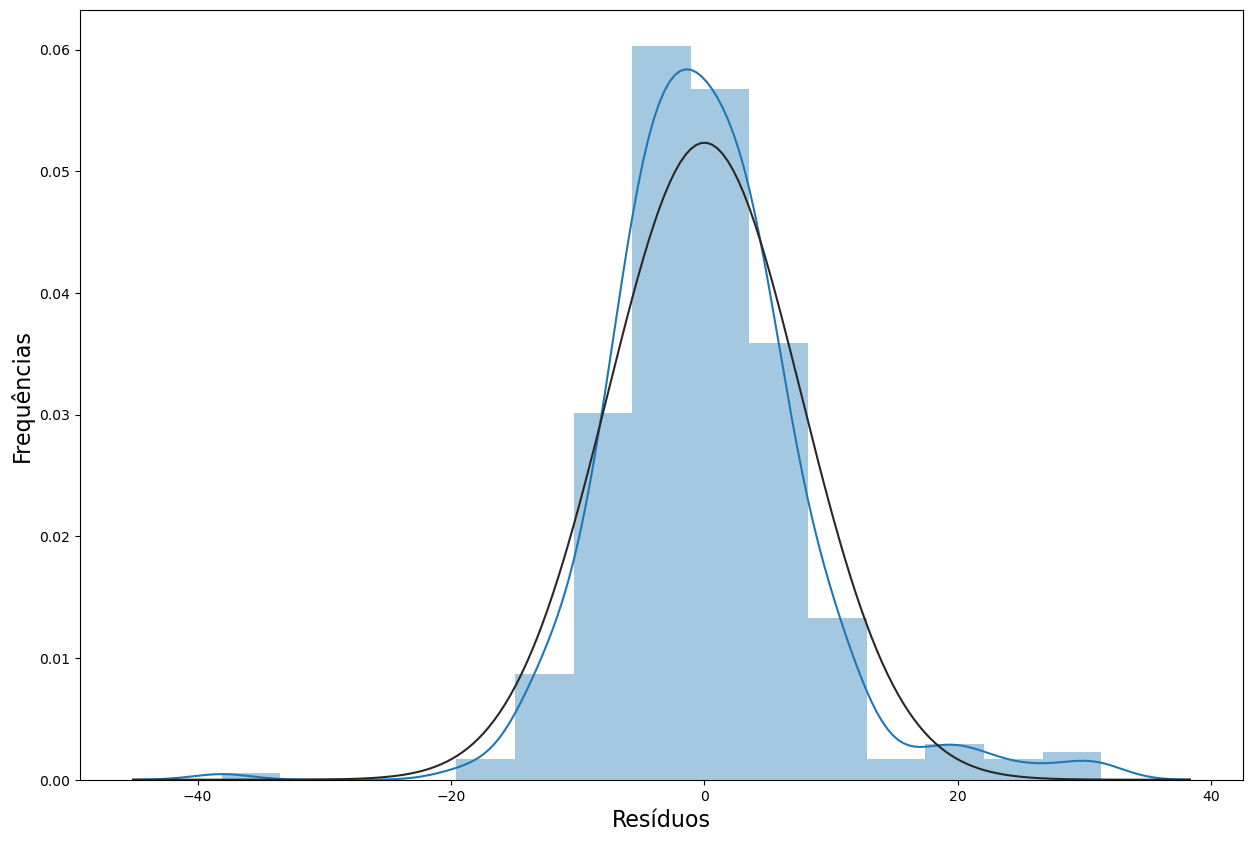

In [71]:
plt.figure(figsize=(15,10))
sns.distplot(modelo_sm_step.resid, fit=norm, kde=True, bins=15)
plt.xlabel('Resíduos', fontsize=16)
plt.ylabel('Frequências', fontsize=16)
plt.show()

> Iremos fazer a transformação de Box-Cox


### Heterocedasticidade (Teste de Breusch Pagan)

In [72]:
# Criando Função para Teste de Breusch Pagan
def breusch_pagan_test(modelo):

    df = pd.DataFrame({'yhat':modelo.fittedvalues,
                       'resid':modelo.resid})
   
    df['up'] = (np.square(df.resid))/np.sum(((np.square(df.resid))/df.shape[0]))
   
    modelo_aux = sm.OLS.from_formula('up ~ yhat', df).fit()
   
    anova_table = sm.stats.anova_lm(modelo_aux, typ=2)
   
    anova_table['sum_sq'] = anova_table['sum_sq']/2
    
    chisq = anova_table['sum_sq'].iloc[0]
   
    p_value = stats.chi2.pdf(chisq, 1)*2
    
    print(f"chisq: {chisq}")
    
    print(f"p-value: {p_value}")
    
    return chisq, p_value

In [73]:
breusch_pagan_test(modelo_sm_step)

chisq: 3.9241409207892106
p-value: 0.05661759140598009


(3.9241409207892106, 0.05661759140598009)

> Resultou um p-val >0.05 , portanto o modelo NÃO apresentou HETEROCEDASTICIDADE!!!

### Transformação de Box-Cox

> Irei fazer a transformação de Box-Cox para tentar fazer com que os resíduos do modelo seja aderente à normal

In [74]:
# Transformação de Box-Cox
x, lmbda = boxcox(df_modelo['Preco_por_unidade_de_area'])

print('Primeiros valores da variável target: ', x[:5])
print('lambda', lmbda)

Primeiros valores da variável target:  [21.53618779 23.57681468 25.94347743 29.33277212 23.99848251]
lambda 0.7979813782707401


In [75]:
df_modelo

,Idade_casa,Distancia_da_estacao_metro,Numero_lojas_conveniencia,Ano_Transacao_2013,Mes_Transacao_Q2,Mes_Transacao_Q3,Mes_Transacao_Q4,Preco_por_unidade_de_area
0,1.244653,-0.959923,1.983040,0,0,0,1,37.9
1,0.174269,-0.645261,1.625537,0,0,0,1,42.2
2,-0.356642,-0.282808,0.195525,1,0,1,0,47.3
3,-0.356642,-0.282808,0.195525,1,0,0,0,54.8
4,-1.067377,-0.526084,0.195525,0,0,0,1,43.1
...,...,...,...,...,...,...,...,...
368,0.088638,2.007464,-0.519482,1,1,0,0,28.1
369,-1.015998,-0.952008,1.625537,0,0,1,0,50.0
370,0.114327,-0.525514,0.910531,1,0,0,0,40.6
371,-0.801921,-0.931636,0.195525,1,0,0,0,52.5


In [76]:
# Inserindo o lambda de Box-Cox no dataset para a estimação de um novo modelo (após a transformação)
df_modelo_bc = df_modelo.copy()
df_modelo_bc['Preco_por_unidade_de_area'] = x

In [77]:
# Criando modelo com os novos dados
modelo_sm_bc = sm.OLS.from_formula('Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro +\
                                            Numero_lojas_conveniencia + Ano_Transacao_2013 + Mes_Transacao_Q2 +\
                                            Mes_Transacao_Q3 + Mes_Transacao_Q4', df_modelo_bc).fit()

In [78]:
# Summary
modelo_sm_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Preco_por_unidade_de_area   R-squared:                       0.573
Model:                                   OLS   Adj. R-squared:                  0.564
Method:                        Least Squares   F-statistic:                     69.84
Date:                       Thu, 23 Mar 2023   Prob (F-statistic):           1.50e-63
Time:                               11:22:41   Log-Likelihood:                -1008.8
No. Observations:                        373   AIC:                             2034.
Df Residuals:                            365   BIC:                             2065.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     20.9534      0.622     33.699      0.000      19.731      22.176
Idade_casa                    -1.6434      0.191     -8.606      0.000      -2.019      -1.268
Distancia_da_estacao_metro    -3.0325      0.229    -13.266      0.000      -3.482      -2.583
Numero_lojas_conveniencia      1.3541      0.229      5.922      0.000       0.904       1.804
Ano_Transacao_2013             1.6425      0.644      2.550      0.011       0.376       2.909
Mes_Transacao_Q2              -0.7784      0.503     -1.548      0.122      -1.767       0.210
Mes_Transacao_Q3               0.6561      0.663      0.989      0.323      -0.648       1.960
Mes_Transacao_Q4               0.3744      0.773      0.484      0.628      -1.145       1.894
==============================================================================
Omnibus:                       48.874   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.947
Skew:                           0.355   Prob(JB):                     7.98e-58
Kurtosis:                       7.051   Cond. No.                         7.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
# Procedimento stepwise
modelo_sm_bc_step = stepwise(modelo_sm_bc, pvalue_limit= 0.05)

Regression type: OLS 

Estimating model...: 
 Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro + Numero_lojas_conveniencia + Ano_Transacao_2013 + Mes_Transacao_Q2 + Mes_Transacao_Q3 + Mes_Transacao_Q4

 Discarding atribute "Mes_Transacao_Q4" with p-value equal to 0.6283356353521704 

Estimating model...: 
 Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro + Numero_lojas_conveniencia + Ano_Transacao_2013 + Mes_Transacao_Q2 + Mes_Transacao_Q3

 Discarding atribute "Mes_Transacao_Q3" with p-value equal to 0.3882753234291486 

Estimating model...: 
 Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro + Numero_lojas_conveniencia + Ano_Transacao_2013 + Mes_Transacao_Q2

 Discarding atribute "Mes_Transacao_Q2" with p-value equal to 0.08671375249898838 

Estimating model...: 
 Preco_por_unidade_de_area ~ Idade_casa + Distancia_da_estacao_metro + Numero_lojas_conveniencia + Ano_Transacao_2013

 No more atributes with p-value higher than 0.05


In [80]:
# Summary do modelo pós stepwise
modelo_sm_bc_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Preco_por_unidade_de_area   R-squared:                       0.568
Model:                                   OLS   Adj. R-squared:                  0.563
Method:                        Least Squares   F-statistic:                     120.9
Date:                       Thu, 23 Mar 2023   Prob (F-statistic):           9.10e-66
Time:                               11:22:41   Log-Likelihood:                -1010.8
No. Observations:                        373   AIC:                             2032.
Df Residuals:                            368   BIC:                             2051.
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     21.3208      0.340     62.680      0.000      20.652      21.990
Idade_casa                    -1.6072      0.190     -8.446      0.000      -1.981      -1.233
Distancia_da_estacao_metro    -3.0415      0.228    -13.358      0.000      -3.489      -2.594
Numero_lojas_conveniencia      1.3409      0.228      5.890      0.000       0.893       1.789
Ano_Transacao_2013             1.0858      0.410      2.649      0.008       0.280       1.892
==============================================================================
Omnibus:                       50.060   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.104
Skew:                           0.350   Prob(JB):                     2.03e-62
Kurtosis:                       7.218   Cond. No.                         3.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Fazendo teste Shapiro Francia novamente pra ver se o problema de aderência dos Resíduos à normalidade foi solucionado

In [81]:
shapiroFrancia(modelo_sm_bc_step.resid)

{'method': 'Shapiro-Francia normality test',
 'statistics W': 0.9388818381971293,
 'statistics z': 6.106213956711571,
 'p-value': 5.101111241811176e-10}

## Conclusão

> Apesar de o modelo não apresentar mais heterocedasticidade, o modelo continuou com o problema de não aderência à normalidade dos resíduos.  
> Portanto isso pode afetar as estimativas dos coeficientes de regressão, além de afetar a validade dos testes estatítisticos como o teste t e F por exemplo.  

> Logo, o ideal é procurar outros modelos mais sofisticados para fazer a predição dessa base de dados em específico (como RNN, Ensemble, modelos hierárquicos, mistos, etc).  >
> Além disso, mesmo que tivessemos tido um modelo adequado, nossa acurácia não foi tão alta, com um valor de aproximadamente 56%